In [1]:
from pathlib import Path
import sys
papylio_path = Path.cwd()
for i in range(20):
    papylio_path = papylio_path.parent
    if papylio_path.name == 'papylio':
        break
        
sys.path.append(str(papylio_path))
import papylio as pp

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

experiment_path = papylio_path / 'tests' / 'integration' / 'data' / 'Papylio example dataset - analyzed'
experiment_path

exp = pp.Experiment(experiment_path)
file = exp.files.select('HJ', 'name')[0]

Import files: 100%|██████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 3022.38it/s]



Initialize experiment: 
C:\Users\user\surfdrive\Promotie\Code\Python\papylio\tests\integration\data\Papylio example dataset - analyzed


# Histogram fit

A common method of determining the reaction parameters is fitting the dwell time histogram with an exponential distribution:

$$
\text{PDF} = \sum_{i=1}^{n} P_i k_i e^{-k_i t}
$$

To fit this function, we need the dwell time histogram in the form of the probability density function. To obtain it we normalize the histogram and divide by the bin width:

$$
\text{bin}_{i,\text{PDF}} = \frac{\text{bin}_{i}}{N_{\text{total}}\, \Delta t_{\text{bin}}}
$$

where $N_{\text{total}}$ is the total number of dwell times and $\Delta t_{\text{bin}}$ is the bin width.

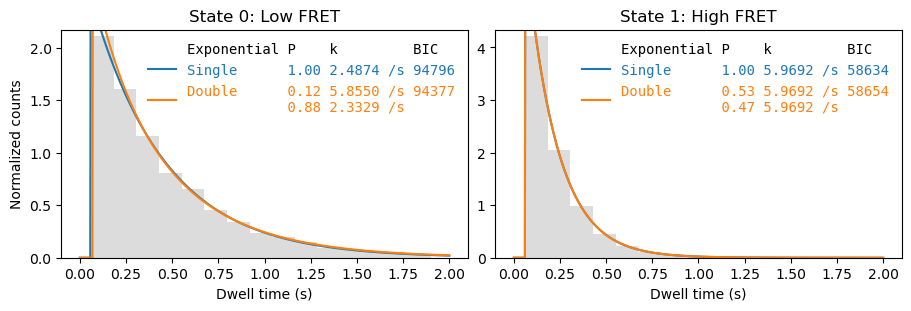

In [2]:
fig, axes = plt.subplots(1,2, figsize=(9,3), layout='constrained')
_ = file.analyze_dwells(method='histogram_fit', number_of_exponentials=[1,2], state_names={0: 'Low FRET',  1:'High FRET'},
                       plot=True, plot_dwell_analysis_kwargs=dict(plot_range=(0,2), axes=axes))

## Bin size

The fit result depends on the chosen bin width. The default ways of determining a proper bin width in numpy may not give good results for our data, mainly because our data is already binned in the time dimension with bin edges at the start and end of each frame.

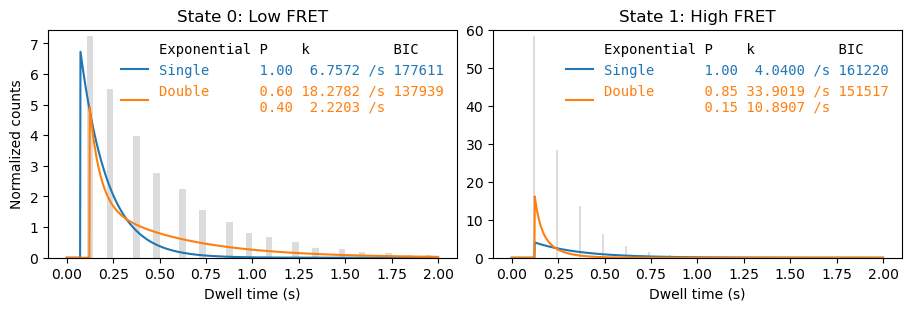

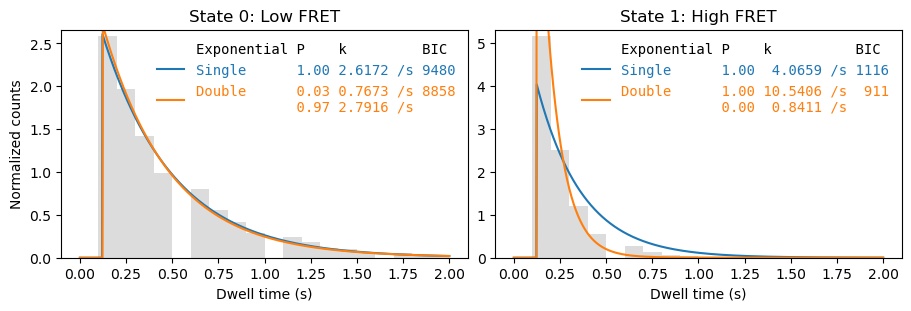

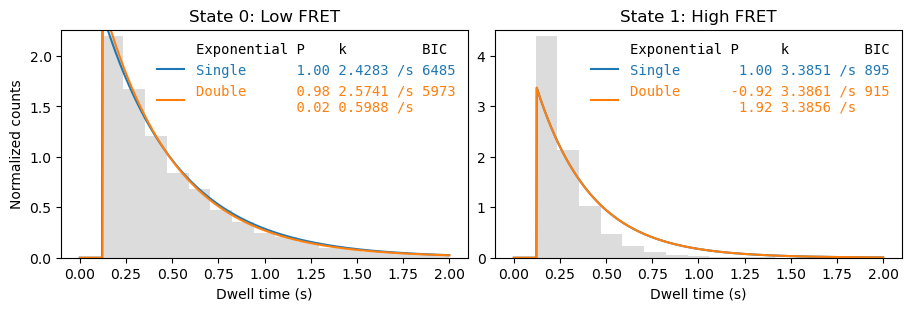

In [3]:
for bins in ['auto', 20, 'sturges']:
    fig, axes = plt.subplots(1,2, figsize=(9,3), layout='constrained')
    _ = file.analyze_dwells(method='histogram_fit', number_of_exponentials=[1,2], state_names={0: 'Low FRET',  1:'High FRET'},
                           fit_dwell_times_kwargs=dict(bins=bins), plot=True, plot_dwell_analysis_kwargs=dict(bins=bins, plot_range=(0,2), axes=axes))

Hence we use a binning method that takes into account the frame interval by making the bin width a multiple of the frame interval $\Delta t_{\text{frame}}$. To determine the number of multiples we estimate the bin width using the Freedman-Diaconis rule

$$
\Delta t_{\text{bin, fd}} = 2 \frac{\text{IQR(x)}}{N^{1/3}}
$$

and then round up to a integer number of the frame interval:

$$
\Delta t_{\text{bin}} = \text{ceil}\left( \frac{\Delta t_{\text{bin, fd}}}{\Delta t_{\text{frame}}} \right) \Delta t_{\text{frame}}
$$

Additonally, the first bin starts at half the frame interval, so that the bin centers correspond to the time points of the frames.

## Truncation
As we fit the probability density function, it is also important to use a truncated distribution.

Text(0.5, 0.98, 'No truncation')

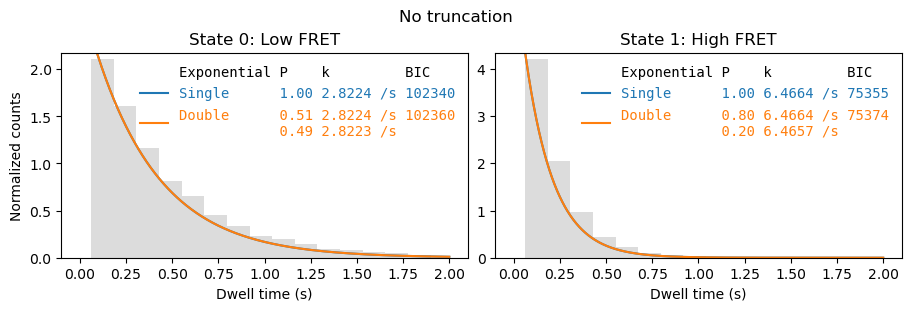

In [4]:
fig, axes = plt.subplots(1,2, figsize=(9,3), layout='constrained')
_ = file.analyze_dwells(method='histogram_fit', number_of_exponentials=[1,2], state_names={0: 'Low FRET',  1:'High FRET'},
                        truncation=(0, np.inf), fit_dwell_times_kwargs=dict(free_truncation_min=False), 
                        plot=True, plot_dwell_analysis_kwargs=dict(plot_range=(0,2), axes=axes))
fig.suptitle('No truncation')

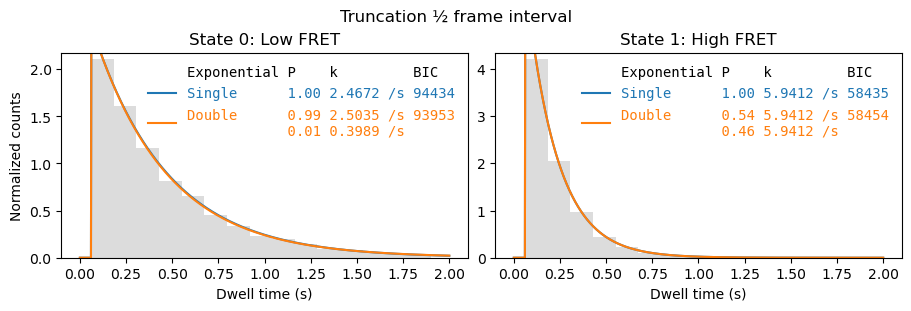

In [5]:
fig, axes = plt.subplots(1,2, figsize=(9,3), layout='constrained')
file.analyze_dwells(method='histogram_fit', number_of_exponentials=[1,2], state_names={0: 'Low FRET',  1:'High FRET'}, 
                    truncation=(file.cycle_time/2, np.inf), fit_dwell_times_kwargs=dict(free_truncation_min=False), 
                    plot=True, plot_dwell_analysis_kwargs=dict(plot_range=(0,2), axes=axes))
_ = fig.suptitle('Truncation ½ frame interval')

We can also add the lower truncation value as an extra fit parameter:

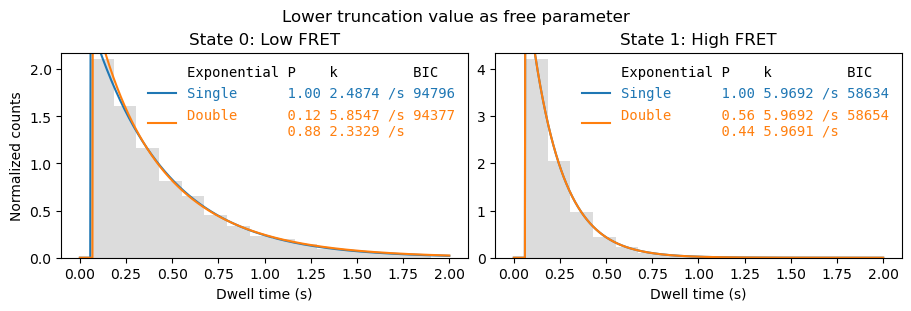

In [6]:
fig, axes = plt.subplots(1,2, figsize=(9,3), layout='constrained')
_ = file.analyze_dwells(method='histogram_fit', number_of_exponentials=[1,2], state_names={0: 'Low FRET',  1:'High FRET'},
                        truncation=(0, np.inf), fit_dwell_times_kwargs=dict(free_truncation_min=True), 
                        plot=True, plot_dwell_analysis_kwargs=dict(plot_range=(0,2), axes=axes))
_ = fig.suptitle('Lower truncation value as free parameter')